# You Only Look Once (YOLO)

You Only Look Once (YOLO) and its variants are one of the prominent object
detection algorithms. In this section, we will understand at a high level how YOLO
works and the potential limitations of R-CNN-based object detection frameworks that
YOLO overcomes.

First, let's learn about the possible limitations of R-CNN-based detection algorithms.
In Faster R-CNN, we slide over the image using anchor boxes and identify the regions
that are likely to contain an object, and then we make the bounding box corrections.
However, in the fully connected layer, where only the detected region's RoI pooling
output is passed as input, in the case of regions that do not fully encompass the object
(where the object is beyond the boundaries of the bounding box of region proposal),
the network has to guess the real boundaries of object, as it has not seen the full image
(but has seen only the region proposal).

YOLO comes in handy in such scenarios, as it looks at the whole image while
predicting the bounding box corresponding to an image.

Furthermore, Faster R-CNN is still slow, as we have two networks: the RPN and the
final network that predicts classes and bounding boxes around objects.

Here, we will understand how YOLO overcomes the limitations of Faster R-CNN,
both by looking at the whole image at once as well as by having a single network to
make predictions. We will look at how data is prepared for YOLO through the
following example:

### 1. Create a ground truth to train a model for a given image:

- Let's consider an image with the given ground truth of bounding
boxes in red:

![imgs](./imgs/o9.png)

- Divide the image into N x N grid cells – for now, let's say N=3:

![imgs](./imgs/o11.png)

- Identify those grid cells that contain the center of at least one ground
truth bounding box. In our case, they are cells b1 and b3 of our 3 x 3
grid image.

- The cell(s) where the middle point of ground truth bounding box falls
is/are responsible for predicting the bounding box of the object. Let's
create the ground truth corresponding to each cell.

- The output ground truth corresponding to each cell is as follows:

![imgs](./imgs/o10.png)

Here, <b> pc </b> (the objectness score) is the probability of the cell containing
an object.
Let's understand how to calculate <b> bx </b>, <b> by </b>, <b> bw </b>, and <b> bh </b>.

First, we consider the grid cell (let's consider the <b> b1 </b> grid cell) as our
universe, and normalize it to a scale between 0 and 1, as follows:

![imgs](./imgs/o12.png)

<b> bx </b> and <b> by </b> are the locations of the mid-point of the ground truth
bounding box with respect to the image (of the grid cell), as defined
previously. In our case, <b> bx </b> = 0.5, as the mid-point of the ground truth is
at a distance of 0.5 units from the origin. Similarly, <b> by </b> = 0.5:

![imgs](./imgs/o13.png)

So far, we have calculated offsets from the grid cell center to the
ground truth center corresponding to the object in the image. Now,
let's understand how <b> bw </b> and <b> bh </b> are calculated.
 
<b> bw </b> is the ratio of the width of the bounding box with respect to the the
width of the grid cell.

<b> bh </b> is the ratio of the height of the bounding box with respect to the
height of the grid cell.

Next, we will predict the class corresponding to the grid cell. If we
have three classes (c1 – truck, c2 – car, c3 – bus), we will predict the
probability of the cell containing an object among any of the three
classes. Note that we do not need a background class here, as <b> pc </b>
corresponds to whether the grid cell contains an object.

Now that we understand how to represent the output layer of each cell,
let's understand how we construct the output of our 3 x 3 grid cells.

- Let's consider the output of the grid cell <b> a3 </b>:

![imgs](./imgs/o14.png)

The output of cell <b> a3 </b> is as shown in the preceding screenshot. As the
grid cell does not contain an object, the first output ( <b> pc </b> – objectness
score) is 0 and the remaining values do not matter as the cell does not
contain the center of any ground truth bounding boxes of an object.

- Let's consider the output corresponding to grid cell <b> b1 </b>:

![imgs](./imgs/o15.png)

The preceding output is the way it is because the grid cell contains an
object with the <b> bx </b>, <b> by </b>, <b> bw </b>, and <b> bh </b> values that were obtained in the
same way as we went through earlier (in the bullet point before last),
and finally the class being car resulting in c2 being 1 while c1 and c3
are 0.

Note that for each cell, we are able to fetch 8 outputs. Hence, for the 3 x
3 grid of cells, we fetch 3 x 3 x 8 outputs.


### 2. Define a model where the input is an image and the output is 3 x 3 x 8 with the ground truth being as defined in the previous step:

![imgs](./imgs/o16.png)

### 3. Define the ground truth by considering the anchor boxes.

So far, we have been building for a scenario where the expectation is that
there is only one object within a grid cell. However, in reality, there can be
scenarios where there are multiple objects within the same grid cell. This
would result in creating ground truths that are incorrect. Let's understand
this phenomenon through the following example image:

![imgs](./imgs/o17.png)

In the preceding example, the mid-point of the ground truth bounding
boxes for both the car and the person fall in the same cell – cell b1.

One way to avoid such a scenario is by having a grid that has more rows
and columns – for example, a 19 x 19 grid. However, there can still be a
scenario where an increase in the number of grid cells does not help.
Anchor boxes come in handy in such a scenario. Let's say we have two
anchor boxes – one that has a greater height than width (corresponding to
the person) and another that has a greater width than height (corresponding
to the car):

![imgs](./imgs/o18.png)

Typically, the anchor boxes would have the grid cell center as their centers.
The output for each cell in a scenario where we have two anchor boxes is
represented as a concatenation of the output expected of the two anchor
boxes:

![imgs](./imgs/o19.png)

Here, bx, by, bw, and bh represent the offset from the anchor box (which is
the universe in this scenario as seen in the image instead of the grid cell).

From the preceding screenshot, we see we have an output that is 3 x 3 x 16,
as we have two anchors. The expected output is of the shape N x N x
( num_classes + 1) x ( num_anchor_boxes ), where N x N is the number of
cells in the grid, num_classes is the number of classes in the dataset, and
num_anchor_boxes is the number of anchor boxes.

### 4. Now we define the loss function to train the model.

When calculating the loss associated with the model, we need to ensure that
we do not calculate the regression loss and classification loss when the
objectness score is less than a certain threshold (this corresponds to the cells
that do not contain an object).

Next, if the cell contains an object, we need to ensure that the classification
across different classes is as accurate as possible.

Finally, if the cell contains an object, the bounding box offsets should be as
close to expected as possible. However, since the offsets of width and height
can be much higher when compared to the offset of the center (as offsets of
the center range between 0 and 1, while the offsets of width and height need
not), we give a lower weightage to offsets of width and height by fetching a
square root value.

Calculate the loss of localization and classification as follows:

![imgs](./imgs/o20.png)


The overall loss is a sum of classification and regression loss values.

## Training YOLO on a custom dataset

In [ ]:
import os
if not os.path.exists('darknet'):
    !git clone https://github.com/AlexeyAB/darknet
    %cd darknet
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    # !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    !make
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

Cloning into 'darknet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14333 (delta 0), reused 0 (delta 0), pack-reused 14330
Receiving objects: 100% (14333/14333), 12.89 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (9776/9776), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-varia

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x

In [ ]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [ ]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [ ]:
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

In [ ]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg
# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg
# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg
# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg
# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg
# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Streaming output truncated to the last 5000 lines.
 total_bbox = 28861, rewritten_bbox = 0.266796 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.253837, GIOU: 0.226252), Class: 0.512278, Obj: 0.035657, No Obj: 0.003119, .5R: 0.000000, .75R: 0.000000, count: 3, class_loss = 1.006398, iou_loss = 0.030554, total_loss = 1.036951 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.272861, GIOU: 0.124810), Class: 0.489438, Obj: 0.001360, No Obj: 0.001263, .5R: 0.000000, .75R: 0.000000, count: 4, class_loss = 1.592821, iou_loss = 0.524624, total_loss = 2.117445 
 total_bbox = 28868, rewritten_bbox = 0.266731 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.441726, GIOU: 0.394106), Class: 0.537547, Obj: 0.008450, No Obj: 0.002911, .5R: 0.200000, .75R: 0.000000, count: 5, class_loss = 1.765674, iou_loss = 0.170821, total_loss = 1.936495 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.533825, GIOU: 0.

2020-11-09 03:24:37.260 | INFO     | torch_snippets.loader:Glob:181 - 3 files found at pred_*.png


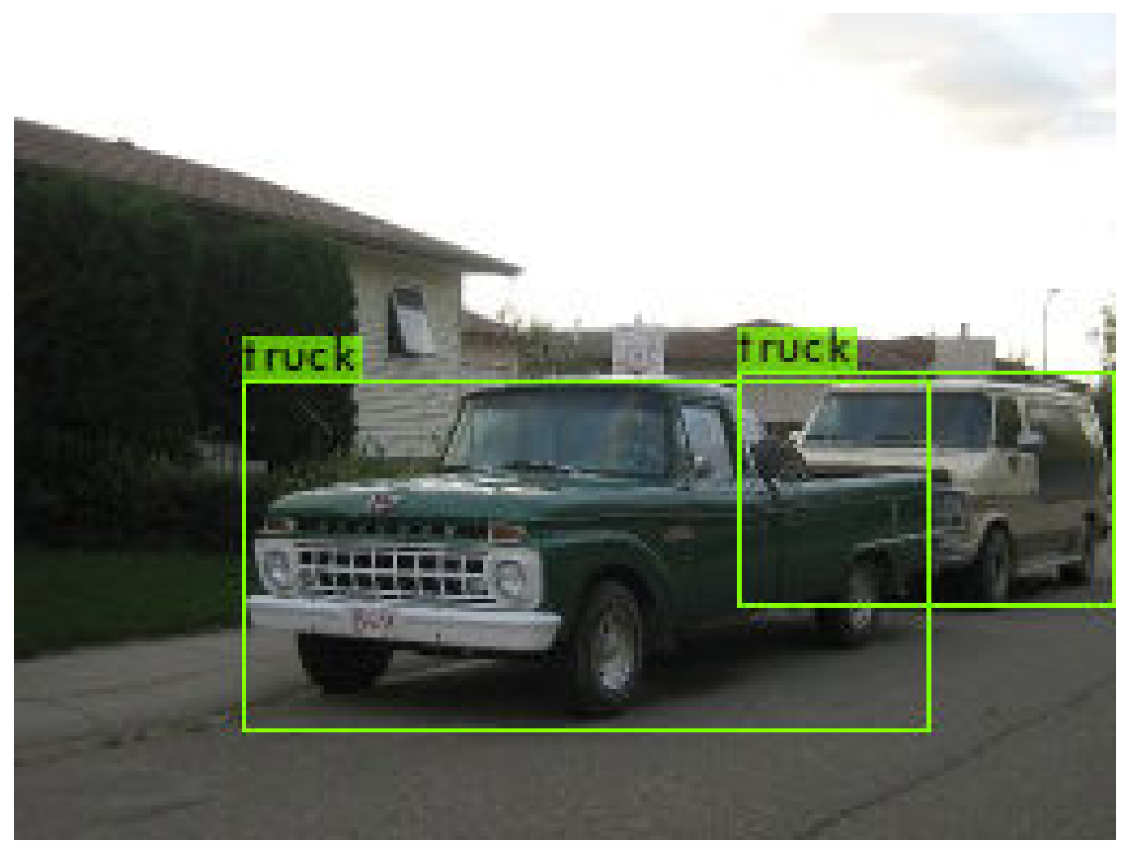

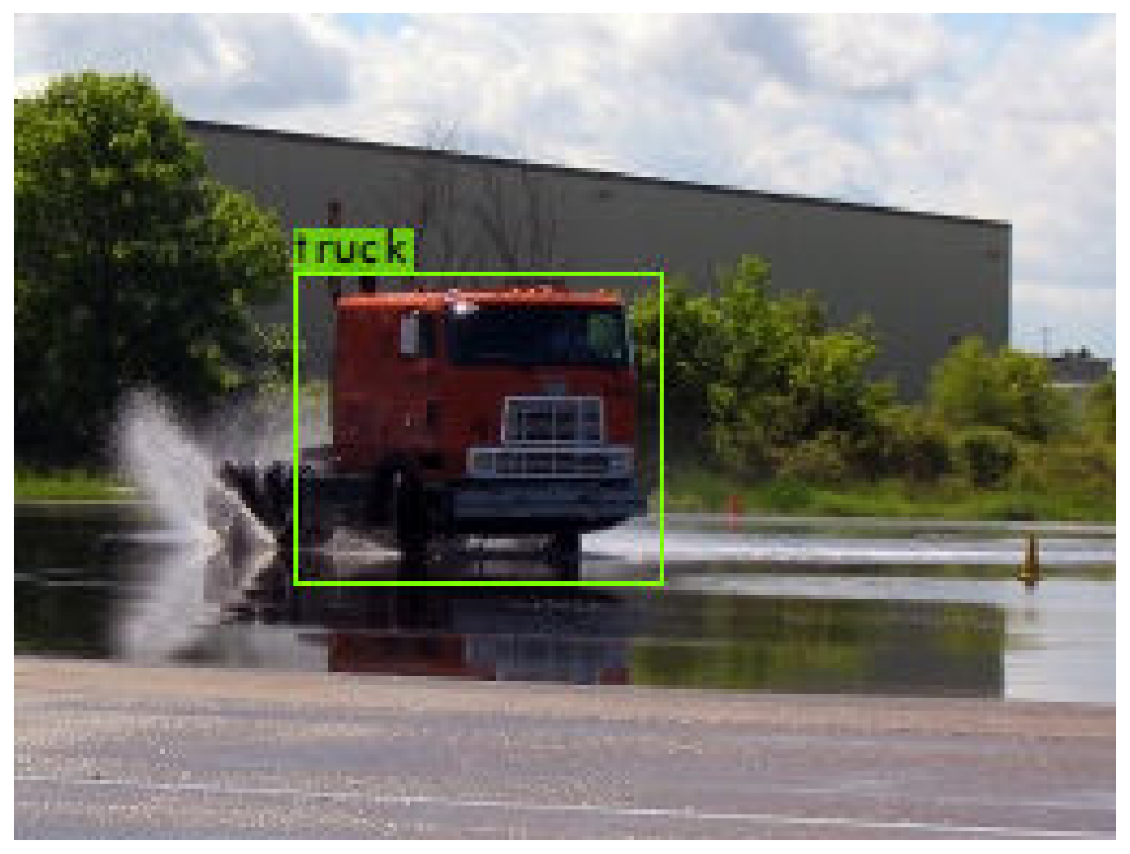

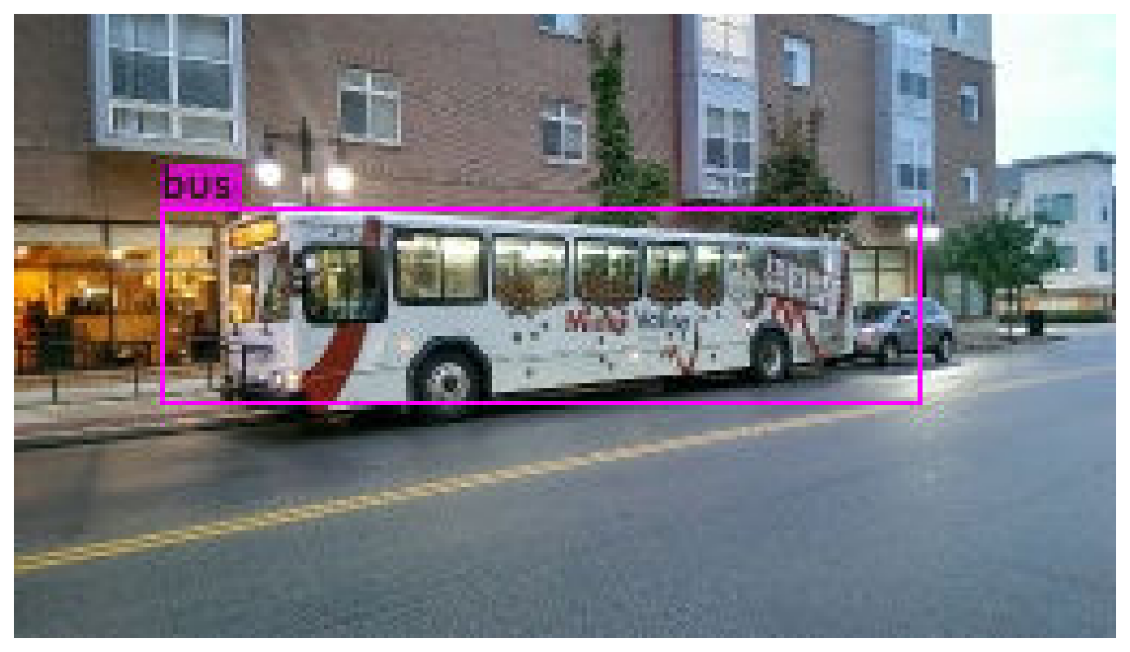

In [5]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = Glob('images-of-trucks-and-busses')
for f in image_paths:
    !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg\
    backup/yolov4-tiny-bus-trucks_4000.weights {f}
    !mv predictions.jpg {stem(f)}_pred.jpg

for i in Glob('*_pred.jpg', silent=True):
    show(read(i, 1), sz=20)